<div style="text-align: center;">
<h1>Reel Realities: How Gender and Age Shape Success Across Box Office and Streaming Platforms</h1>
</div>

### <u>Imports</u>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import math

from src.data.dataloader import (
    CMUDatasetLoader, IMDBDatasetLoader, KaggleDatasetLoader, NumbersDatasetLoader)
import src.utils.data_utils as data_utils
import src.utils.evaluation_utils as evaluation_utils
import warnings

# Suppress specific FutureWarnings about is_sparse being deprecated
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn', message='.*is_sparse is deprecated.*')

### 1. <u>Data cleaning and pre-processing</u>

#### 1.1 CMU Dataset

We will use three files of the CMU dataset:
1. "plot_summaries.txt" gives us the plots of the movies.
2. "movie.metadata.tsv" gives us information about the languages, countries, and genres of the movies.
3. "character.metadata.tsv" gives us information about actors and the characters they play.

In [2]:
directory = "data"
CMU_loader = CMUDatasetLoader(directory)
plot_summaries_df = CMU_loader.load_plot_summaries()

print(f"The plot summaries dataframe has {len(plot_summaries_df):,} values.")

The plot summaries dataframe has 42,303 values.


In [3]:
null_id = plot_summaries_df["Wikipedia_movie_ID"].isnull().sum()
empty_id = plot_summaries_df[plot_summaries_df["Wikipedia_movie_ID"] == ""]["Wikipedia_movie_ID"].sum()
null_plot = plot_summaries_df["Plot Summaries"].isnull().sum()
empty_plot = plot_summaries_df[plot_summaries_df["Plot Summaries"] == ""]["Plot Summaries"].sum()

print(f"Number of null values in 'Wikipedia_movie_ID': {null_id}")
print(f"Number of empty values in 'Wikipedia_movie_ID': {empty_id}")
print(f"Number of null values in 'Plot Summaries': {null_plot}")
print(f"Number of empty values in 'Plot Summaries': {empty_plot}")

Number of null values in 'Wikipedia_movie_ID': 0
Number of empty values in 'Wikipedia_movie_ID': 0
Number of null values in 'Plot Summaries': 0
Number of empty values in 'Plot Summaries': 0


In [4]:
movie_metadata_df = CMU_loader.load_movie_metadata()
print(f"The movie metadata dataframe has {len(movie_metadata_df):,} values.")

The movie metadata dataframe has 81,741 values.


In [5]:
movie_metadata_df["Movie_name"] = (movie_metadata_df["Movie_name"]
                    .str.strip()  #Remove leading/trailing whitespace
                    .str.lower()  #Convert to lowercase
                    .replace("", np.nan)  #Replace empty strings with NaN
                   )

In [6]:
# Movie languages, countries, and genres are formatted as a dictionary, but they are actually a string.
# We convert them to comma seperated strings. 

column_names_to_clean = ["Movie_countries", "Movie_languages", "Movie_genres"]
movie_metadata_df = data_utils.convert_dicts_to_strings(movie_metadata_df, column_names_to_clean)

In [7]:
#Cleaning
movie_metadata_df = data_utils.clean_string_columns(movie_metadata_df, column_names_to_clean)

In [8]:
# There are inconsistencies in the date format: some rows have the date as year only, others as year-month, and some as year-month-day. 
# We convert them all to the year format only since the month and day are not relevant to our analysis.
movie_metadata_df, date_pattern_summary = data_utils.standardize_dates(movie_metadata_df, "Movie_release_date")
print("Pattern Summary:\n", date_pattern_summary)

Pattern Summary:
                        Pattern  Count
0       Full Date (YYYY-MM-DD)  39373
1             Year Only (YYYY)  32172
2                      Missing   6902
3  Year & Month Date (YYYY-MM)   3294


In [9]:
n_null_movie_metadata = ((movie_metadata_df.isnull().sum() / len(movie_metadata_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"movie_metadata_df:\n{n_null_movie_metadata}"
)

Percentage of null values per column:
movie_metadata_df:
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           8.44%
Movie_box_office_revenue    89.72%
Movie_runtime               25.02%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres                 0.00%
dtype: object


In [10]:
character_metadata_df = CMU_loader.load_character_metadata()

In [11]:
character_metadata_df['Actor_name']= character_metadata_df['Actor_name'].fillna('unknown').str.lower()

# Ensures that the date columns are correctly interpreted as datetime objects in pandas. 
character_metadata_df['Movie_release_date'] = pd.to_datetime(character_metadata_df['Movie_release_date'], errors='coerce').dt.date
character_metadata_df['Actor_date_of_birth'] = pd.to_datetime(character_metadata_df['Actor_date_of_birth'], errors='coerce').dt.date

# Drop rows where 'Movie_release_date' or 'Actor_date_of_birth' is NaT
character_metadata_df.dropna(subset=['Movie_release_date', 'Actor_date_of_birth'], inplace=True)

# Calculate Actor_age_at_movie_release if missing and data is available
character_metadata_df['Actor_age_at_movie_release'] = character_metadata_df.apply(
    lambda row: (row['Movie_release_date'] - row['Actor_date_of_birth']).days // 365 if pd.isnull(row['Actor_age_at_movie_release']) else row['Actor_age_at_movie_release'],
    axis=1
)

In [12]:
print(f"Movies without actor gender data: {character_metadata_df['Actor_gender'].isnull().sum()}") 

Movies without actor gender data: 892


We therefore drop the movies with no information on the gender of the actors.

In [13]:
character_metadata_df.dropna(subset=['Actor_gender'], inplace=True)

Now, let's group the actors together by creating a *Cast* column on the *movie_metadata_df*. 

In [14]:
cast_per_movie = character_metadata_df.groupby('Freebase_movie_ID')['Actor_name'].apply(lambda x: ', '.join(x)).reset_index()
cast_per_movie = cast_per_movie.rename(columns={'Actor_name': 'Cast'})

movie_metadata_df = movie_metadata_df.merge(cast_per_movie, on='Freebase_movie_ID', how='left')

In [15]:
missing_cast_count = movie_metadata_df["Cast"].isna().sum()
total_movies = len(movie_metadata_df)
print(f"Movies without actor data: {missing_cast_count} out of {total_movies} ({missing_cast_count / total_movies * 100:.2f}%)")

Movies without actor data: 48556 out of 81741 (59.40%)


We decide to drop the movies without actor data since it is one of the most important data of our study. 

In [16]:
movie_metadata_df = movie_metadata_df.dropna(subset = ['Cast'])

In [17]:
# Create columns for male, female actor counts
actor_counts = character_metadata_df.groupby('Freebase_movie_ID')['Actor_gender'].value_counts().unstack(fill_value=0)
actor_counts = actor_counts.rename(columns={'M': 'Male_actors', 'F': 'Female_actors'})

# Ensure all columns are present (set missing columns to 0 if necessary)
for col in ['Male_actors', 'Female_actors']:
    if col not in actor_counts.columns:
        actor_counts[col] = 0

actor_counts = actor_counts.reset_index()

# Merge actor counts with the movie_metadata_df DataFrame
movie_metadata_df = movie_metadata_df.merge(actor_counts, on='Freebase_movie_ID', how='left')

# Fill NaN values with 0 
movie_metadata_df[['Male_actors', 'Female_actors']] = movie_metadata_df[['Male_actors', 'Female_actors']].fillna(0)

In [18]:
# Calculate the percentage of female actors in each movie and round to two decimal places
movie_metadata_df['Female_actor_percentage'] = (
    (movie_metadata_df['Female_actors'] / 
     (movie_metadata_df['Female_actors'] + movie_metadata_df['Male_actors'])) * 100
).round(2)

#### 1.2 IMDB Dataset

We will use two IMDB datasets to decribe movies:
1. "title.ratings.tsv" gives us the ratings of the movies as voted by viewers. 
2. "title.basics.tsv", indexes into "title.ratings.tsv" using a alphanumeric unique identifier of the title. It gives general information about the movie such as runtime, release date and adult rating.
3. "title.crew.tsv", indexes into the previous two using the same alphanumeric unique identifier of the title. It gives information on the directors and writers of the movie.

Reference:
Internet Movie Database. (2024). IMDb non-commercial datasets. Retrieved from https://developer.imdb.com/non-commercial-datasets/

In [19]:
# Loading the IMDB datasets.
IMDB_loader = IMDBDatasetLoader(directory)
IMDB_ratings_df = IMDB_loader.load_ratings()

IMDB_basics_df = IMDB_loader.load_basics()

IMDB_crew_df = IMDB_loader.load_crew()

In [20]:
# Checking the lengths of the datasets
print(f"Length of IMDB_ratings_df: {len(IMDB_ratings_df):,}\n"
      f"Length of IMDB_basics_df: {len(IMDB_basics_df):,}\n"
      f"Length of IMDB_crew_df: {len(IMDB_crew_df):,}")

Length of IMDB_ratings_df: 1,498,616
Length of IMDB_basics_df: 697,175
Length of IMDB_crew_df: 10,571,537


Before dealing with the null values we will merge the dataframes together using the alphanumeric unique identifier.

In [21]:
# Merging all three datasets.
IMDB_merged_df = pd.merge(IMDB_ratings_df, IMDB_basics_df, how="inner", left_on="tconst", right_on="tconst")
IMDB_merged_df = pd.merge(IMDB_merged_df, IMDB_crew_df, how="inner", on="tconst")

In [22]:
print(f"The resulting merged dataframe has length: {len(IMDB_merged_df):,}.")

The resulting merged dataframe has length: 319,293.


Formatting the strings appropriately.

In [23]:
IMDB_merged_df = data_utils.clean_string_columns(IMDB_merged_df, ["Original_title", "Primary_title"])

We can now look at null values in the merged IMDB dataframe.

In [24]:
# Checking the percentage of null values in the dataset.
n_null_IMDB = ((IMDB_merged_df.isnull().sum() / len(IMDB_merged_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"IMDB_ratings_df:\n{n_null_IMDB}"
)

Percentage of null values per column:
IMDB_ratings_df:
tconst               0.00%
Average_ratings      0.00%
Num_votes            0.00%
Title_type           0.00%
Primary_title        0.00%
Original_title       0.00%
Is_adult             0.00%
Start_year           0.01%
End_year           100.00%
Movie_runtime        9.98%
Movie_genres         3.26%
Directors            0.98%
Writers             12.30%
dtype: object


The end year is always missing. Other than that the proportion of missing values is very small (< 12%). End year is always null for movies and only makes sense for TV shows. It can thus be dropped. We can also drop the titleType column since we know they are all movies after the filtering that was done above.

In [25]:
# Dropping unnecessary columns.
IMDB_merged_df = IMDB_merged_df.drop(columns=["End_year", "Title_type"], axis=1)

print(f"The resulting dataframe has {len(IMDB_merged_df):,} rows.")

The resulting dataframe has 319,293 rows.


We will use ratings from the IMDB dataset during our study. However, these ratings are based on viewer votes. Initially we thought of discarding rows with too few votes. However, there could be a link between number of votes and number of views of a movie (although definitely not a direct one). We thus decided to keep all rows for the analysis.

#### 1.3 Merging the datasets

##### 1.3.1 Merging IMDB and CMU Movies

In [26]:
# Merging on the original title.
merge1 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on="Original_title", right_on="Movie_name")
# Merging on the primary title.
merge2 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on="Primary_title", right_on="Movie_name")

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
movie_df = pd.concat([merge1, merge2]).drop_duplicates(subset=["tconst"]).reset_index(drop=True)

print(f"The resulting dataframe has {len(movie_df):,} rows.")

The resulting dataframe has 38,550 rows.


Some columns appear twice. Let's take a look at the proportion of null values in each duplicate column.

In [27]:
n_null_movie = (movie_df.isnull().sum()/len(movie_df)).apply(lambda x:f"{x:.2%}")

print(f"Percentage of null values per column:\n{n_null_movie}")

Percentage of null values per column:
tconst                       0.00%
Average_ratings              0.00%
Num_votes                    0.00%
Primary_title                0.00%
Original_title               0.00%
Is_adult                     0.00%
Start_year                   0.00%
Movie_runtime_x              5.50%
Movie_genres_x               1.41%
Directors                    0.43%
Writers                      5.31%
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           0.00%
Movie_box_office_revenue    73.83%
Movie_runtime_y             10.74%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres_y               0.00%
Cast                         0.00%
Female_actors                0.00%
Male_actors                  0.00%
Female_actor_percentage      0.00%
dtype: object


We can see:
- Movie_runtime_x and Movie_runtime_y have 6.02% and 11.58% missing values respectively. We will combine the non null values from both these columns into a new column called runtimeMinutes and then drop the previous two columns. 
- Movie_genres_x has 1.54% missing values against 0.00% missing values for Movie_genres_y. Furthermore Movie_genres_y is from the CMU dataset and seems more complete. We will thus drop the genres_x column.

In [28]:
# Combining all non-null values from Movie_runtime_x and Movie_runtime_y into runtimeMinutes.
movie_df["Movie_runtime"] = movie_df["Movie_runtime_x"].combine_first(movie_df["Movie_runtime_y"])

# Dropping the unnecessary columns.
movie_df.drop(columns=["Movie_runtime_x", "Movie_runtime_y", "Movie_genres_x"], inplace=True)

Let's now see if Movie_name, originalTitle and primaryTitle are all necessary or if there are any redundancies.

In [29]:
test1 = movie_df["Movie_name"] == movie_df["Primary_title"]  
test2 = movie_df["Movie_name"] == movie_df["Original_title"]

# Checking if there are any movies for which Movie_name is not either in Primary_title or Original_title
print(f"There are {(~(test1 | test2)).sum().item()} movies for which Movie_name is in neither Primary_title ot Original_title.")

There are 0 movies for which Movie_name is in neither Primary_title ot Original_title.


We can see the Movie_name column is redundant as its information is either in primaryTitle or in originalTitle. We can thus drop this column.

In [30]:
movie_df.drop(columns="Movie_name", inplace=True)

We can now also drop movie identifier columns (as everything is already indexed): tconst and Freebase_movie_ID

In [31]:
movie_df.drop(columns=["tconst", "Freebase_movie_ID"], inplace=True)

To connect this with the plot_summaries_df, we perform a left merge.

In [32]:
movie_df = pd.merge(movie_df, plot_summaries_df, on="Wikipedia_movie_ID", how="left")

Finally, we can drop Wikipedia_movie_ID, which is also a movie identifier column.

In [33]:
movie_df.drop(columns="Wikipedia_movie_ID", inplace=True)

##### 1.3.3 Merging Kaggle and The numbers datasets to the rest

We have a problem, a lot of missing values(NaN or 0) in Movie box office revenue in movie_df and no production budget included. 
These two new datasets include information about movies revenue and budget and other attributes which are crucial for our analysis.

- `Kaggle_df`: Contains important details about movies, including budgets, genres, and revenue.
- `TheNumbers_df`: Provides detailed financial data, focusing on budget and box office gross both domestically and worldwide.

In [34]:
Kaggle_df = KaggleDatasetLoader(directory).load_kaggle()
TheNumbers_df = NumbersDatasetLoader(directory).load_numbers()

Quickly view the structure of the dataframes to understand the data types and confirm data has loaded correctly

In [35]:
Kaggle_df.head()

,budget,genres,original_title,popularity,production_companies,production_countries,revenue
0,237000000.0,Action Adventure Fantasy Science Fiction,Avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.787965e+09
1,300000000.0,Adventure Fantasy Action,Pirates of the Caribbean: At World's End,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",9.610000e+08
2,245000000.0,Action Adventure Crime,Spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",8.806746e+08
3,250000000.0,Action Crime Drama Thriller,The Dark Knight Rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1.084939e+09
4,260000000.0,Action Adventure Science Fiction,John Carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.841391e+08


In [36]:
TheNumbers_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [37]:
# Clean and convert financials to float for consistency with the movie_df
TheNumbers_df = data_utils.clean_currency_columns(TheNumbers_df, ["production_budget", "domestic_gross", "worldwide_gross"])

In [38]:
TheNumbers_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


We now perform an outer merge to include all records from both datasets, aligning them based on movie titles.


In [39]:
# Normalize the title columns for case insensitive matching
Kaggle_df = data_utils.clean_string_columns(Kaggle_df, ["original_title"])
TheNumbers_df = data_utils.clean_string_columns(TheNumbers_df, ["movie"])

# Merge both dataframes on the title columns
merged_df = pd.merge(Kaggle_df, TheNumbers_df, left_on="original_title", right_on="movie", how='outer')
merged_df.head()

,budget,genres,original_title,popularity,production_companies,production_countries,revenue,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,237000000.0,Action Adventure Fantasy Science Fiction,avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.787965e+09,1.0,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09
1,300000000.0,Adventure Fantasy Action,pirates of the caribbean: at world's end,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",9.610000e+08,NaN,NaN,NaN,NaN,NaN,NaN
2,245000000.0,Action Adventure Crime,spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",8.806746e+08,10.0,"Nov 6, 2015",spectre,300000000.0,200074175.0,8.796209e+08
3,250000000.0,Action Crime Drama Thriller,the dark knight rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1.084939e+09,11.0,"Jul 20, 2012",the dark knight rises,275000000.0,448139099.0,1.084439e+09
4,260000000.0,Action Adventure Science Fiction,john carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.841391e+08,14.0,"Mar 9, 2012",john carter,275000000.0,73058679.0,2.827781e+08


##### Post-merge cleaning

We create the main financial columns ('movie_budget' and 'movie_revenue') by selecting non-null and non-zero values, prioritizing data from TheNumbers dataset when available.


In [40]:
merged_df["movie_budget"] = np.where((merged_df["production_budget"].notna() & (merged_df["production_budget"] != 0)),
                                     merged_df["production_budget"],
                                     merged_df["budget"])

merged_df["movie_revenue"] = np.where((merged_df["worldwide_gross"].notna() & (merged_df["worldwide_gross"] != 0)),
                                      merged_df["worldwide_gross"],
                                      merged_df["revenue"])

# Drop the original columns that were merged into new ones
merged_df.drop(columns=["budget", "revenue", "production_budget", "worldwide_gross", "movie"], inplace=True)

merged_df.head()

,genres,original_title,popularity,production_companies,production_countries,id,release_date,domestic_gross,movie_budget,movie_revenue
0,Action Adventure Fantasy Science Fiction,avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1.0,"Dec 18, 2009",760507625.0,425000000.0,2.776345e+09
1,Adventure Fantasy Action,pirates of the caribbean: at world's end,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",NaN,NaN,NaN,300000000.0,9.610000e+08
2,Action Adventure Crime,spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",10.0,"Nov 6, 2015",200074175.0,300000000.0,8.796209e+08
3,Action Crime Drama Thriller,the dark knight rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",11.0,"Jul 20, 2012",448139099.0,275000000.0,1.084439e+09
4,Action Adventure Science Fiction,john carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",14.0,"Mar 9, 2012",73058679.0,275000000.0,2.827781e+08


Filter out movies where both budget and revenue data are missing or zero, as they do not provide value for financial analysis.


In [41]:
# Create a mask where both columns are either zero or NaN
mask = (
    (merged_df["movie_budget"].isna() | (merged_df["movie_budget"] == 0)) &
    (merged_df["movie_revenue"].isna() | (merged_df["movie_revenue"] == 0))
)

# Apply the mask and drop those rows
df_filtered = merged_df[~mask]

In [42]:
print("The number of available and relevant movie budget and revenue information is " + str(df_filtered["movie_budget"].size))

df_filtered.head()

The number of available and relevant movie budget and revenue information is 6125


,genres,original_title,popularity,production_companies,production_countries,id,release_date,domestic_gross,movie_budget,movie_revenue
0,Action Adventure Fantasy Science Fiction,avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1.0,"Dec 18, 2009",760507625.0,425000000.0,2.776345e+09
1,Adventure Fantasy Action,pirates of the caribbean: at world's end,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",NaN,NaN,NaN,300000000.0,9.610000e+08
2,Action Adventure Crime,spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",10.0,"Nov 6, 2015",200074175.0,300000000.0,8.796209e+08
3,Action Crime Drama Thriller,the dark knight rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",11.0,"Jul 20, 2012",448139099.0,275000000.0,1.084439e+09
4,Action Adventure Science Fiction,john carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",14.0,"Mar 9, 2012",73058679.0,275000000.0,2.827781e+08


Two merging strategies are employed here to maximize the potential for matching records across the datasets:

Original Title Merge: Merging based on the Original_title from movie_df to the original_title from df_filtered to catch the most direct title matches. 

Primary Title Merge: Using Primary_title as an alternative matching criterion, knowing that some movies might be listed under alternate titles.


In [43]:
# Normalize the title columns for case-insensitive matching
movie_df["Original_title"] = movie_df["Original_title"].str.strip().str.lower()
movie_df["Primary_title"] = movie_df["Primary_title"].str.strip().str.lower()

# Merging on the original title.
merge1 = pd.merge(movie_df, df_filtered, how="left", left_on="Original_title", right_on="original_title")
# Merging on the secondary title.
merge2 = pd.merge(movie_df, df_filtered, how="left", left_on="Primary_title", right_on="original_title")

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
final_df = pd.concat([merge1, merge2]).drop_duplicates().reset_index(drop=True)

# Filter out movies where revenue data is missing or zero and prioritize initial revenue
final_df["final_movie_revenue"] = np.where(
    (final_df["Movie_box_office_revenue"].notna() & (final_df["Movie_box_office_revenue"] != 0)),
    final_df["Movie_box_office_revenue"],
    final_df["movie_revenue"]
)

final_df.drop(columns=["Movie_box_office_revenue", "movie_revenue", "original_title", "genres", "id", "release_date"], inplace=True, errors='ignore')

# Renaming the columns to follow the convention
rename_columns = {"popularity":"Popularity", 
                  "production_companies":"Production_companies", 
                  "prodcution_countries":"Production_countries",
                  "domestic_gross":"Domestic_gross",
                  "movie_budget":"Movie_budget",
                  "final_movie_revenue":"Final_movie_revenue",
                  "Movie_genres_y":"Movie_genres"}

final_df.rename(columns=rename_columns, inplace=True)


print(f"The resulting dataframe has {len(final_df):,} rows.")
final_df.head()

The resulting dataframe has 40,008 rows.


,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,Movie_languages,...,Male_actors,Female_actor_percentage,Movie_runtime,Plot Summaries,Popularity,Production_companies,production_countries,Domestic_gross,Movie_budget,Final_movie_revenue
0,5.2,540,the corbett-fitzsimmons fight,the corbett-fitzsimmons fight,0,1897,nm0714557,NaN,1897,,...,1,0.0,100,The film no longer exists in its entirety; how...,NaN,NaN,NaN,NaN,NaN,100000.0
1,5.7,28,the prodigal son,l'enfant prodigue,0,1907,nm0141150,nm0141150,1907,french language,...,1,50.0,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.1,12,l'enfant prodigue,l'enfant prodigue,0,1916,nm0141150,nm0141150,1907,french language,...,1,50.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.3,27,robbery under arms,robbery under arms,0,1907,nm0533958,"nm0092809,nm0533958",1985,english language,...,5,0.0,141.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.2,49,robbery under arms,robbery under arms,0,1920,nm0104270,"nm0092809,nm0104270",1985,english language,...,5,0.0,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. <u>Our success metric</u>

#### Financial Analysis

##### Calculating Return on Investment (ROI)

To provide insights into the financial success of the movies, we calculate the Return on Investment (ROI). This metric is derived by comparing the movie's final revenue to its budget.

- **Condition**: Ensure that both `movie_budget` and `final_movie_revenue` are non-zero and non-null to avoid division errors and ensure data integrity


In [44]:
final_df = evaluation_utils.calculate_roi(final_df, "Movie_budget", "Final_movie_revenue")
print("There is now " + str(final_df["Final_movie_revenue"].size) + " movies to work with in the financial success analysis")

There is now 6468 movies to work with in the financial success analysis


#### Data Normalization and Scaling

Given the varied scales of ratings and ROI, we standardize these features to a common scale using both Standard and Min-Max scalers. 

In [45]:
# Initialize scalers
final_df = evaluation_utils.scale_features(final_df)

#### Weighted Success Metric

To evaluate overall movie success, we calculate a weighted sum of normalized ratings and ROI, assigning double the weight to ROI given its financial significance in assessing success.

In [46]:
# Calculate movie success which is a weighted sum choosing that the ROI feature will have double the importance of ratings
final_df = evaluation_utils.calculate_weighted_success(final_df, 0.67)

final_df.head()

,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,Movie_languages,...,Production_companies,production_countries,Domestic_gross,Movie_budget,Final_movie_revenue,ROI,Normalized_Rating,Log_ROI,Movie_success,Scaled_movie_success
7,4.7,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,german language,...,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",4501094.0,18000000.0,7129670.0,-0.603907,0.47,0.349927,0.389551,0.381656
8,4.7,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,german language,...,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1577287.0,2000000.0,2419669.0,0.209835,0.47,0.408189,0.428587,0.442113
9,3.8,22,hamlet,hamlet,0,1911,nm0088881,nm0000636,1921,german language,...,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",4501094.0,18000000.0,7129670.0,-0.603907,0.38,0.349927,0.359851,0.335658
10,3.8,22,hamlet,hamlet,0,1911,nm0088881,nm0000636,1921,german language,...,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1577287.0,2000000.0,2419669.0,0.209835,0.38,0.408189,0.398887,0.396115
11,5.0,81,hamlet,hamlet,0,1913,nm0687575,nm0000636,1921,german language,...,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",4501094.0,18000000.0,7129670.0,-0.603907,0.50,0.349927,0.399451,0.396989


### 3. <u>Gender and age vs success</u>

Now that we have have established our success metric, we can evaluate the effect of actors' gender on the success of a movie. 

The best way we chose in order to conduct our analysis is a **Regression analysis**. Indeed, this will allow us to quantify and understand the relationship between gender, age, and other factors on ROI, ratings and our success metric while controlling for potential confounders.

Before diving into regression, we should perform an **Exploratory Data Analysis (EDA)** to understand the relationships among variables and detect any anomalies.

#### 1.1 Exploratory Data Analysis (EDA)

First, let's list the variable of interest:

Categorical variable:
- *Actor_gender*: An actor is either Male or Female. 
- *isAdult*: A boolean. Returns 1 if it a +18 rated movie
- *Movie_genre*
- *Movie_countries*, 
- *Movie_languages*

Continous variable:
- *Average_female_actor_age*: Represents the average age of the female actresses. 
- *Average_male_actor_age*: Represents the average age of the male actresses.
- *Average_ratings* and *Movie_box_office_revenue*: These are the dependent variables of our studies.    



##### A quick comment about the dependent variables:
The goal of our study is to look at ratings, ROI and our succes metric. However, due to complications with finding enough data for the ROI and success metric estimation we will need to postpone the in-depth analysis to P3.

##### 1.1.1 Univariate Analysis of continuous variables
a. <u>Numerical Analysis</u>: 

As a numerical analysis, we can show a table with tne minimum, maximum, mean, standar deviation (SD) and median of each variable.


In [47]:
final_df_copy = final_df.copy()

In [ ]:
# TODO: add here Log_ROI and Movie_success

numeric_columns = ["Average_ratings",
                   "Num_votes",
                   "Movie_release_date",
                   "Final_movie_revenue",
                   #"ROI",
                   "Movie_runtime",
                   "Female_actors",
                   "Male_actors"]

In [49]:
pd.options.display.float_format = "{:,.2f}".format

for col in numeric_columns:
    final_df_copy[col] = pd.to_numeric(final_df_copy[col], errors="coerce")

final_df_copy.dropna(subset=numeric_columns, inplace=True)

# Summary statistics
summary_table = final_df_copy[numeric_columns].agg(["min", "max", "mean", "std", "median"]).T
summary_table.columns = ["Min", "Max", "Mean", "SD", "Median"]
summary_table = summary_table.round(2)

summary_table

,Min,Max,Mean,SD,Median
Average_ratings,1.20,10.00,6.28,1.17,6.40
Num_votes,5.00,"2,962,241.00","82,688.95","191,770.20","10,590.00"
Movie_release_date,"1,910.00","2,014.00","1,993.12",23.25,"2,002.00"
Final_movie_revenue,423.00,"2,782,275,172.00","98,109,238.64","177,826,125.90","39,686,769.00"
ROI,-1.00,"101,981.64",21.37,"1,270.18",0.83
Log_ROI,0.00,1.00,0.42,0.08,0.43
Movie_success,0.14,0.79,0.49,0.07,0.50
Scaled_movie_success,0.00,1.00,0.54,0.11,0.55
Movie_runtime,4.00,450.00,103.82,24.64,100.00
Female_actors,0.00,20.00,3.52,2.45,3.00


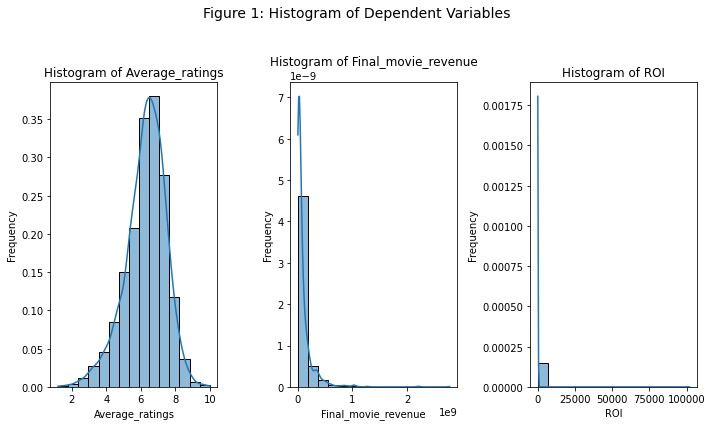

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
fig.suptitle("Figure 1: Histogram of Dependent Variables", fontsize=14)
axes = axes.flatten()

dep_var = ["Average_ratings", "Final_movie_revenue", "ROI"]

# Plot histograms for each dependent variables
for i, col in enumerate(dep_var):
    if i < len(axes):  # Ensure we do not exceed the number of axes
        ax = axes[i]
        sns.histplot(final_df_copy, x=col, kde=True, stat="density", ax=ax, bins=15)
        ax.set_title(f"Histogram of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")

# Hide any extra subplots if there are more axes than columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Make space for the title
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

As we can see in Figure 1, the distribution of *Final_movi_revenue* and *ROI* are highly skewed. In order to adresse that, we have to apply a log transformation to them.

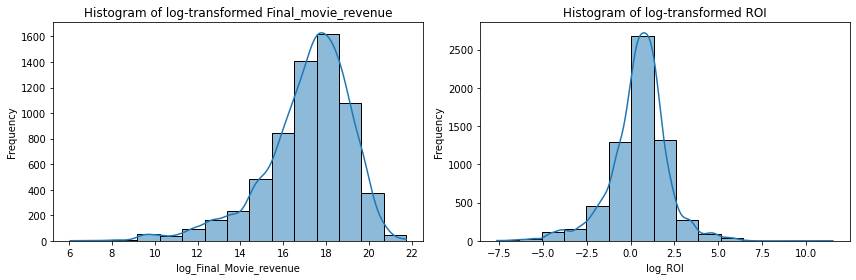

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram for Log_Final_movie_revenue
sns.histplot(final_df_copy['Final_movie_revenue'].apply(math.log1p), kde=True, edgecolor="black", bins=15, ax=axes[0])
axes[0].set_title("Histogram of log-transformed Final_movie_revenue")
axes[0].set_xlabel("log_Final_Movie_revenue")
axes[0].set_ylabel("Frequency")

# Histogram for log_ROI
sns.histplot(final_df_copy['ROI'].apply(math.log1p), kde=True, edgecolor="black", bins=15, ax=axes[1])
axes[1].set_title("Histogram of log-transformed ROI")
axes[1].set_xlabel("log_ROI")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Now we have successfully obtained a normal distribution for the *Final_Movie_revenue* and *ROI*. 

Let's now look at our independent variables.

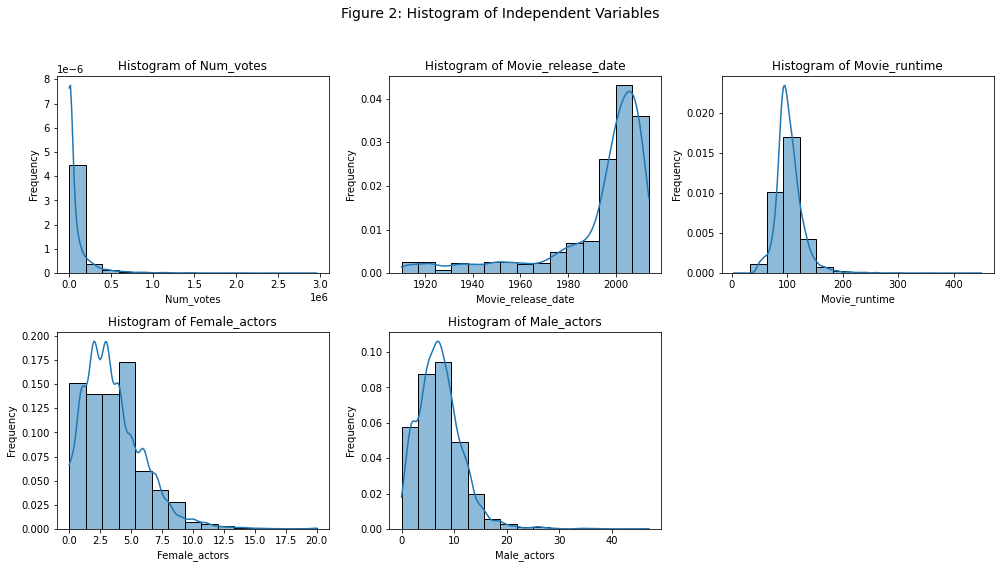

In [52]:
# Same as for the dependent variables
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
fig.suptitle("Figure 2: Histogram of Independent Variables", fontsize=14)

axes = axes.flatten()

indep_var = ["Num_votes", "Movie_release_date", "Movie_runtime", "Female_actors", "Male_actors"]

# Plot histograms for each independent variable
for i, col in enumerate(indep_var):
    sns.histplot(final_df_copy, x=col, kde=True, stat="density", ax=axes[i], bins=15)
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

We need to apply log transformation to the skewed independent variables being: *Num_votes*, *Movie_runtime*, *Female_actors* and *Male_actors*.

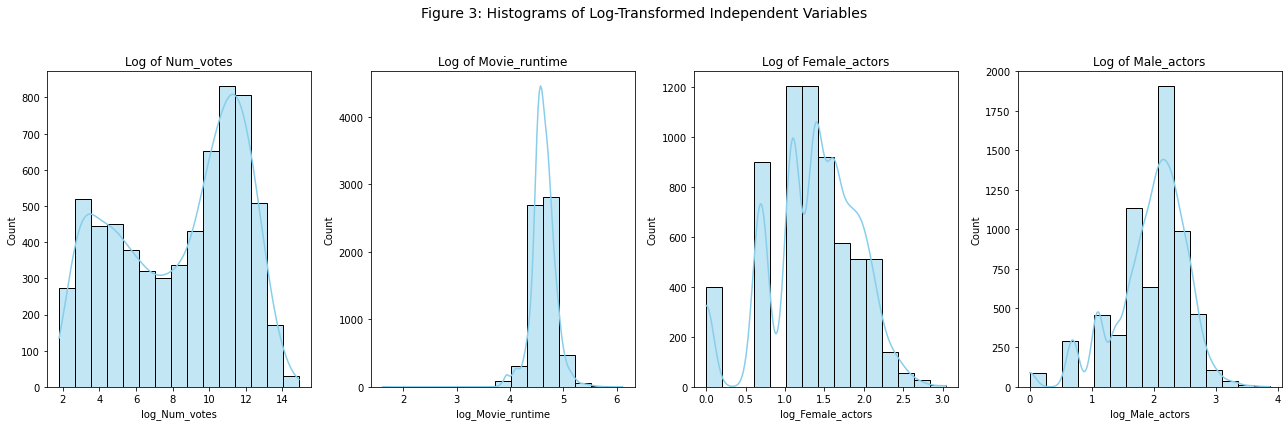

In [53]:
# Apply log transformation to skewed independent variables
final_df_copy = evaluation_utils.log_transform(final_df_copy, ["Num_votes", "Movie_runtime", "Female_actors", "Male_actors"])

# Plot histograms of the transformed variables
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
fig.suptitle("Figure 3: Histograms of Log-Transformed Independent Variables", fontsize=14)

sns.histplot(final_df_copy['log_Num_votes'], kde=True, ax=axes[0], color="skyblue", bins=15)
axes[0].set_title("Log of Num_votes")

sns.histplot(final_df_copy['log_Movie_runtime'], kde=True, ax=axes[1], color="skyblue", bins=15)
axes[1].set_title("Log of Movie_runtime")

sns.histplot(final_df_copy['log_Female_actors'], kde=True, ax=axes[2], color="skyblue", bins=15)
axes[2].set_title("Log of Female_actors")

sns.histplot(final_df_copy['log_Male_actors'], kde=True, ax=axes[3], color="skyblue", bins=15)
axes[3].set_title("Log of Male_actors")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Log of Num_votes: A bimodal distribution, with most movies receiving moderate votes and a smaller group of popular movies getting significantly more votes.

Log of Movie_runtime: Right-skewed, with most movies having runtimes between 50 to 150 minutes (from Figure 2), and few with very long runtimes.

Log of Female_actors: Slightly bimodal, with most movies having a small number of female actors, and a few with more.

Log of Male_actors: Similar to female actors, the distribution is skewed towards movies with fewer male actors, and only a few movies have a large number of male actors.

ValueError: num must be an integer with 1 <= num <= 8, not 9

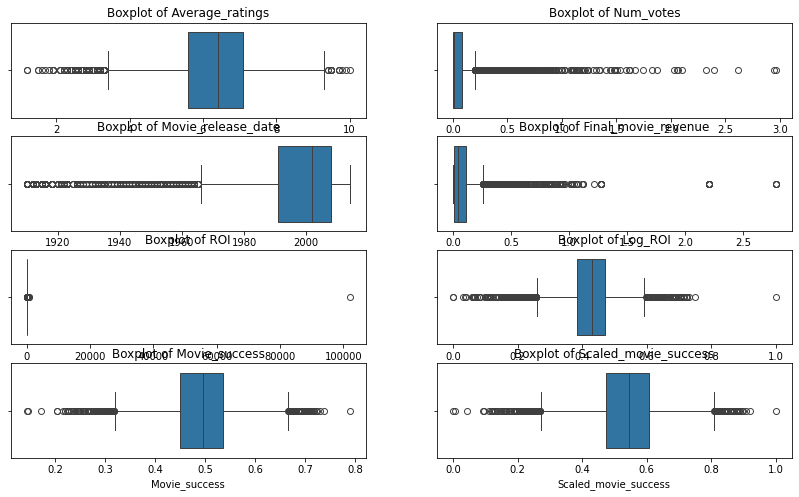

In [54]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=final_df_copy, x=col)
    plt.title(f"Boxplot of {col}")
    
plt.suptitle("Figure 4: Boxplot of Variables")     
plt.tight_layout()
plt.show()

We now have to focus on outliers and removing them for a more accurate modeling. From the boxplots, we chose the remove the outliers of the *Movie_box_office_revenue* and the *Minutes_runtime* variables. To do that, we use the **InterQuartile Range (IQR) method**, which identifies values that are significantly higher or lower than the majority of the data.

The *remove_outliers* function will calculate the IQR for each column specified and removes any rows with values outside the range:

$[Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}]$


In [ ]:
# Create a copy of the dataframe without outliers
final_df_no_outliers = data_utils.remove_outliers(final_df_copy, numeric_columns)

# Display the boxplot again to verify the outliers are removed
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=final_df_no_outliers, x=col)
    plt.title(f"Boxplot of {col} (Without Outliers)")
plt.suptitle("Figure 5: Boxplot of Variables without Outliers")
plt.tight_layout()
plt.show()

In [ ]:
print(f"After removing the outliers and dropping the null values, we are left with {len(final_df_no_outliers):,} movies.")

##### 1.1.2 Bivariate Analysis of continuous variables
a. <u>Correlation matrix</u>:

In [ ]:
correlation_matrix = final_df_no_outliers[numeric_columns].corr()

# Calculate and visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Figure 6: Correlation Matrix of Numeric Variables")
plt.show()

The correlation matrix for the continuous variables in our dataset shows the following relationships:

•⁠  ⁠Female_actors and Male_actors : The correlation coefficient is *0.19*, indicating a weak positive correlation. This suggests that movies with a higher number of female actors also tend to have a higher number of male actors. We note that this could indicate a general tendency for larger casts to include more actors of both genders.

•⁠  ⁠Final_movie_revenue and Male_actors : The correlation coefficient is *0.26*, indicating a moderate positive correlation. This suggests that movies with more male actors might achieve higher box office earnings. 

•⁠  ⁠Final_movie_revenue and Female_actors : The correlation coefficient is *0.16*, indicating a weak positive correlation. This suggests that movies with more female actors also have a slight tendency to generate higher revenue. We note however that this relationship is weaker than with male actors. 

•⁠  ⁠Female_actors and Movie_release_date : The correlation coefficient is *0.15*, indicating a weak positive correlation. This suggests that more recent movies tend to include a higher number of female actors. 

While gender composition affects the correlation, these findings highlight the need for deeper analysis (e.g., regression) to control for potential confounders and isolate the impact of gender on box office success.

b. <u>Scatter plots </u>:

In [ ]:
sns.pairplot(final_df_no_outliers[numeric_columns])

#### The categorical variables
Regression analysis with many categorical variables can quickly get complicated. Indeed using a boolean value for each category except one can cause us to have too many regressors. For variables like isAdult and Gender it is easy as there are only two possibilities. However, for Movie_genre, Movie_countries and Movie_languages we can quickly get into the hundreds. Here is how we plan on managing this:

#### Movie_genre

We set a cutoff threshold of 1000. This means all genres with less than 1000 occurences will be discarded. 

In [ ]:
N = 1000  # Threshold for filtering genres

genres_series = (
    final_df_copy["Movie_genres"]
    .str.replace(r"[\[\]']", "", regex=True)  # Clean the string further for this application
    .str.split(', ')  # Split the genre strings into lists for easier manipulation, using ', ' as the delimiter
    .explode()  # Expand the lists into separate rows with one genre per row
    .str.strip()  # Strip leading and trailing whitespace from each genre
    .str.lower()
)

# Get the count of each genre
genre_counts = genres_series.value_counts()

# Filter out genres with counts < N
filtered_genre_counts = genre_counts[genre_counts >= N]  

# Count the number of genres appearing at least N times
len(filtered_genre_counts) 

Let us check if this restricts our study to too few movies.

In [ ]:
filtered_genre_counts

In [ ]:
# List of genres that meet the threshold
popular_genres = filtered_genre_counts.index.tolist()

# Remove all special characters from the strings to allow proper regex matching
no_special_char = map(re.escape, popular_genres)

# Create regex pattern using the "OR" operator
pattern_genre = '|'.join(no_special_char) 

# Check thanks to the regex pattern if any of the popular genres are in each column of th edataframe
rows_with_popular_genres = final_df_copy["Movie_genres"].str.contains(pattern_genre, case=False, na=False)

print(f"There are {rows_with_popular_genres.sum()} movies that belong to at least one of the {len(filtered_genre_counts)} most popular genres.",
      f"\nThere were {len(final_df_copy)} movies in the dataset before this operation,", 
      f"meaning we lost {(len(final_df_copy) - rows_with_popular_genres.sum())/len(final_df_copy):.2%} of the movies.")

We can drop the movies that have none of the most popular genres. We can also assume that the genres are ordered by relevance. We will thus keep for each movie, the first popular genre that appears. This assumption was made by randomly sampling over 50 movies and manually checking that the first popular genre corresponds to the main genre of the movie.

In [ ]:
def get_main_genre(genres, popular_genres):
    for genre in map(str.strip, genres.split(",")): # Split genres according to "," then remove spaces
        if genre.lower() in popular_genres: # We are going through the list of genres in the order it is presented
            return genre # Return the first genre that is in popular_genres
    
    return np.nan

In [ ]:
final_df_copy = final_df_copy[rows_with_popular_genres]

# Ensuring the popular_genres are lowercase
popular_genres = set(map(str.lower, popular_genres))

# Apply the function to the dataset and store the results in the Main_genre column, also we are combining action, adventure and action/adventure into one category.
final_df_copy["Main_genre"] = final_df_copy["Movie_genres"].str.replace("action", "action/adventure").str.replace("adventure", "action/adventure").apply(lambda x : get_main_genre(x, popular_genres)).str.replace(" ","_")

# Plotting the distribution of main genres
genre_counts = final_df_copy["Main_genre"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,6))
plt.bar(genre_counts.index, genre_counts.values, edgecolor='black')
plt.title("Distribution of Main Genres", fontsize=16)
plt.xlabel("Main Genres", fontsize=14)
plt.ylabel("Number of Movies", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
final_df_copy = pd.get_dummies(final_df_copy, columns=["Main_genre"], drop_first=True) # Reference category is action/adventure
final_df_copy.sample(5)

#### Movie_languages

In [ ]:
language_series = (
    final_df_copy['Movie_languages']
    .str.replace(r"[\[\]']", "", regex=True) 
    .str.split(', ')
    .explode()
    .str.strip()
    .str.lower()
    .str.replace(" language", "")
)


language_count = language_series.value_counts()
language_count.head(10).plot(kind='bar', figsize=(10, 6))
plt.xlabel('Languages')
plt.ylabel('Occurrences')
plt.title('Top 10 Languages by Occurrences')
plt.xticks(rotation=0)
plt.yscale('log')
plt.tight_layout()
plt.show()

We will have an unbalanced dataset with English being much more prominent than other languages.

In [ ]:
top_languages = language_count.index.tolist()

# Dropping all the rows that do not have one of the top 4 languages.
final_df_copy = final_df_copy[final_df_copy['Movie_languages'].str.contains('|'.join(top_languages), case=False, na=False)]

print(f"We are left with {len(final_df_copy)} datapoints.")

We again have certain rows with multiple languages. We must proceed in a similar way to the genres above to obtain the dummy variables.

Categorizing movies into two groups: 
- those available exclusively in English, 
- those available in other languages (which may include English alongside another language).

In [ ]:
# Giving corresponding labels to each row 'English Only' or 'Not Only English'
final_df_copy['Language_Category'] = final_df_copy['Movie_languages'].apply(
    lambda x: 'English_only' if x.lower() == 'english language' else 'Not_only_english'
)

# Creating the dummy variable and dropping the English_only category to be used as the reference category
final_df_copy = pd.get_dummies(final_df_copy, columns=["Language_Category"], drop_first=True)

# Renaming the column.
final_df_copy.rename(columns={'Language_Category_Not_only_english': 'Is_not_only_english'}, inplace=True)

# Counting the number of movies available in other languages
not_only_eng_count = final_df_copy["Is_not_only_english"].sum()

print(f"There are {not_only_eng_count} movies that are available in other languages and {len(final_df_copy)-not_only_eng_count} movies that are only available in English.")

### 1.2 Identifying Potential Confounders
In order to not have bias in our study, it is essential we add the confounders. This means that we have to identify the variables that have an impact on both treatment and outcome, here being the actor gender and the final box office revenue respectivly. The confounders are: 
-  ⁠Movie_genre
-  ⁠Movie_countries
- ⁠Movie_languages

### 4. <u>How does it compare to streaming platforms? Are movies made for these platforms different?</u>

In this section, we want to expand our study by analyzing data from various streaming platforms. We focus on the movies of Netflix, Amazon Prime, Disney+, and Hulu. To achieve this, we created a dataset by merging data from multiple sources found on Kaggle.


This dataset structure enables comprehensive analysis across various dimensions such as gender repartition in the cast, the ratings and description. Using these columns, we can investigate how streaming platform movies differ in content and ratings compared to traditional box office movies.



In [ ]:
from src.scripts.streaming import get_streaming_dataframe

streaming_df = get_streaming_dataframe()

In [ ]:
streaming_df.drop_duplicates(inplace=True)

a. <u>Numerical Analysis</u>: 

In [ ]:
numeric_columns_streaming = ["Average_Rating", "Num_Votes", "Movie_release_date", "Movie_runtime", "Is_Adult", "Female_actors", "Male_actors"]
streaming_df_copy = streaming_df.copy()
streaming_df_copy.head()
streaming_df_copy = streaming_df_copy[streaming_df_copy['Movie_runtime'] != 0.0]

In [ ]:

#streaming_df_copy['duration'] = streaming_df_copy['duration'].str.replace(' min', '', regex=False)

streaming_df_copy['Movie_runtime'] = pd.to_numeric(streaming_df_copy['Movie_runtime'], errors="coerce")
summary_table = streaming_df_copy[numeric_columns_streaming].dropna().agg(["min", "max", "mean", "std", "median"]).T
summary_table.columns = ["Min", "Max", "Mean", "SD", "Median"]
summary_table = summary_table.round(2)
summary_table


b. <u>Graphical Analysis</u>: 

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.histplot(streaming_df_copy, x="Average_Rating", kde=True, stat="density", ax=ax, bins=15)
ax.set_title("Histogram of averageRating")
ax.set_xlabel("Average_Rating")
ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

The streaming ratings have a more balanced distribution than the movie dataframe. This contrast highlights different success metrics: streaming platforms rely on user ratings for a measure of success and box office movies are judged on revenue.
It's more relevant to study the success of a streaming movie based on ratings, we dont need necessarly to have the revenue.

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
fig.suptitle("Figure 2: Histogram of Independent Variables", fontsize=14)

axes = axes.flatten()

indep_var = ["Num_Votes", "Movie_release_date", "Movie_runtime", "Is_Adult", "Female_actors", "Male_actors"]

#Plot histograms for each independent variable
for i, col in enumerate(indep_var):
    sns.histplot(streaming_df_copy, x=col, kde=True, stat="density", ax=axes[i], bins=15)
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Release_year : The majority of movies in the dataset are very recent with an increase after the year 2000.
Duration: The duration of most movies is between 90 and 120 minutes, which is typical for films.
Is_Adult: Most movies are not classified as adult content but we can see that there is an important proportion of movies classified as adult content.
Female_count and male_count: We can see that the number of men is greater than women but this difference is lower than for CMU/IMDB movies.



In [ ]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_columns_streaming, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=streaming_df_copy, x=col)
    plt.title(f"Boxplot of {col}")
    
plt.suptitle("Figure 3: Boxplot of Variables")     
plt.tight_layout()
plt.show()

As we did in the previous part, we now have to focus on outliers and removing them for a more accurate modeling.

In [ ]:
movie_df_no_outliers = data_utils.remove_outliers(streaming_df_copy, numeric_columns_streaming)

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns_streaming, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=movie_df_no_outliers, x=col)
    plt.title(f"Boxplot of {col} (Without Outliers)")
plt.suptitle("Figure 4: Boxplot of Variables without Outliers")
plt.tight_layout()
plt.show()

In [ ]:
print(f"After removing the outliers and dropping the null values, we are left with {len(movie_df_no_outliers):,} movies.")

##### 1.1.2 Bivariate Analysis
a. <u>Correlation matrix</u>:

In [ ]:
#correlation matrix
correlation_matrix = movie_df_no_outliers[numeric_columns_streaming].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Figure 5: Correlation Matrix of Numeric Variables")
plt.show()

The number of votes and gender composition (especially the number of male actors) seem to influence movie duration. It suggests that popularity and cast composition could impact movie production characteristics.
Weak correlations between movie duration and other variables indicate that duration might not strongly determine popularity based on votes.
This correlation matrix suggests further analysis like regression that could help separate and clarify the effects of gender and duration on popularity.

b. <u>Scatter plots </u>:

In [ ]:
sns.pairplot(movie_df_no_outliers[numeric_columns_streaming])

### 5. <u>What are the social reasons behind the presence of female characters in movies? Is it due to sexualization or genuine equality of representation?</u>

The first part of our analysis uses plot summaries to examine whether female characters are portrayed as having agency (taking action and driving the story) or are reduced to sexualized or objectified roles. So far, we have used LLMs, such as ChatGPT Plus, to classify plot summaries based on these criteria (contains/does not contain sexualization of females), which provided useful initial results and validated the approach. However, due to time constraints during milestone 2, we were unable to use more advanced methods, such as zero-shot or few-shot learning with models like OpenAI's GPT-4, T5, or BERT variants, which we plan to explore further in milestone 3.
The second part of our analysis focuses on adult-rated films in the resulting merged dataframe, specifically examining the gender of the actors to understand patterns of representation.